In [31]:
import os
import gdown
import tensorflow as tf
from deepface.commons import functions
import keras
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Dense, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K

In [32]:
def loadModel(
    url="https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5",
):

    num_classes = 7

    model = Sequential()

    # 1st convolution layer
    model.add(Conv2D(64, (5, 5), activation="relu", input_shape=(48, 48, 1)))
    model.add(MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))

    # 2nd convolution layer
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))

    # 3rd convolution layer
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))

    model.add(Flatten())

    # fully connected neural networks
    model.add(Dense(1024, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation="relu"))
    model.add(Dropout(0.2))

    model.add(Dense(num_classes, activation="softmax"))

    # ----------------------------

    home = functions.get_deepface_home()

    if os.path.isfile(home + "/.deepface/weights/facial_expression_model_weights.h5") != True:
        print("facial_expression_model_weights.h5 will be downloaded...")

        output = home + "/.deepface/weights/facial_expression_model_weights.h5"
        gdown.download(url, output, quiet=False)

    model.load_weights(home + "/.deepface/weights/facial_expression_model_weights.h5")

    return model

In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout

def create_model(num_classes, include_top=True):
    model = Sequential()

    # 1st convolution layer
    model.add(Conv2D(64, (5, 5), activation="relu", input_shape=(75, 100, 3)))
    model.add(MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))

    # 2nd convolution layer
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))

    # 3rd convolution layer
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))

    model.add(Flatten())

    # fully connected neural networks
    model.add(Dense(1024, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation="relu"))
    model.add(Dropout(0.2))



    if include_top:
        # Ajouter la dernière couche Dense selon le nombre de classes
        model.add(Dense(num_classes, activation="softmax"))
    
    return model

# Créer le modèle original avec la structure initiale (7 classes)
original_model = loadModel()

# Créer le nouveau modèle avec la structure pour 22 classes
new_model = create_model(num_classes=22)
"""
# Transférer les poids de l'original_model à new_model pour toutes les couches sauf la dernière
for layer, original_layer in zip(new_model.layers[:-1], original_model.layers[:-1]):
    layer.set_weights(original_layer.get_weights())

# Maintenant, new_model a les poids pré-entraînés dans toutes les couches sauf la dernière4
"""


"\n# Transférer les poids de l'original_model à new_model pour toutes les couches sauf la dernière\nfor layer, original_layer in zip(new_model.layers[:-1], original_model.layers[:-1]):\n    layer.set_weights(original_layer.get_weights())\n\n# Maintenant, new_model a les poids pré-entraînés dans toutes les couches sauf la dernière4\n"

In [34]:
import numpy as np
import matplotlib.pyplot as plt

path = "../../Database"
train_dataset, test_dataset = tf.keras.utils.image_dataset_from_directory(
    path,
    label_mode='categorical',
    subset = "both",
    validation_split = 0.2,
    seed=0,
    image_size=(128, 160),
    color_mode='rgb',
    batch_size=32
)
train_dataset_fer, test_dataset_fer = tf.keras.utils.image_dataset_from_directory(
    path,
    label_mode='categorical',
    subset = "both",
    validation_split = 0.2,
    seed=0,
    image_size=(48, 48),
    color_mode='grayscale',
    batch_size=32
)

def normalize(image, label):
    return image / 255.0, label
# Appliquer la normalisation
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)
train_dataset_fer = train_dataset_fer.map(normalize)
test_dataset_fer = test_dataset_fer.map(normalize)



Found 5060 files belonging to 22 classes.
Using 4048 files for training.
Using 1012 files for validation.
Found 5060 files belonging to 22 classes.
Using 4048 files for training.
Using 1012 files for validation.


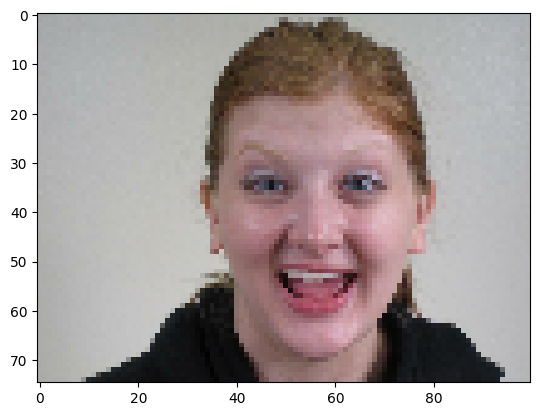

In [35]:
import matplotlib.pyplot as plt

images = next(iter(train_dataset.take(1)))

image = images[0]
path = images[0]
plt.imshow(image[0].numpy())


In [36]:

# Charger le modèle existant
model = create_model(22)
"""
# Créer un nouveau modèle en supprimant la dernière couche et en ajoutant une nouvelle couche Dense
new_output = Dense(22, activation='softmax')(model.layers[-2].output)
model = Model(inputs=model.input, outputs=new_output)
"""


for layer in model.layers:
    print(layer)
    layer.trainable = True
print(len(model.layers))
# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
#model.fit(train_dataset, epochs=50, validation_data=test_dataset)



14


In [37]:
model = tf.keras.saving.load_model("aled")

<AxesSubplot: >

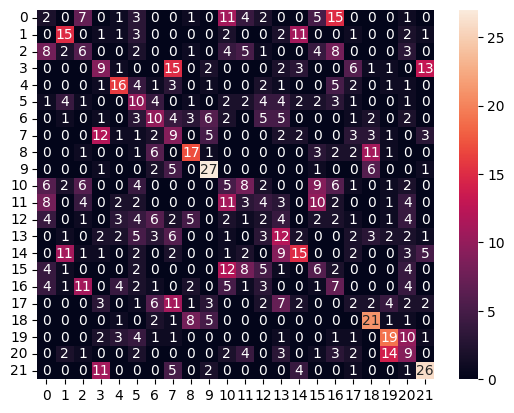

In [38]:
import seaborn as sn
predictions = np.array([])  
labels =  np.array([])
for x, y in test_dataset_fer:
  y_prob = model.predict(x, verbose=0) 
  y_classes = y_prob.argmax(axis=-1)
  predictions = np.concatenate([predictions, y_classes])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

mat = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
sn.heatmap(mat, annot=True)

In [39]:


#Building Model
base_model = tf.keras.applications.MobileNet(input_shape=(128,160,3),include_top=False,weights="imagenet")
for layer in base_model.layers:
    layer.trainable=True
model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(22,activation='softmax'))

# Model Summary

model.summary()



Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 2, 3, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten_15 (Flatten)        (None, 6144)              0         
                                                                 
 dense_45 (Dense)            (None, 1024)              6292480   
                                                                 
 dropout_30 (Dropout)        (None, 1024)              0         
                                                                 
 dense_46 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_31 (Dropout)        (None, 1024)              0         
                                                     

In [40]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val



METRICS = [
      tf.keras.metrics.Accuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.keras')

es = EarlyStopping(verbose=1, patience=20)

model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=["accuracy"])

history=model.fit(train_dataset,validation_data=test_dataset,epochs = 60,verbose = 1,callbacks=[lrd,mcp,es])




Epoch 1/60
127/127 [==============================] - 149s 1s/step - loss: 3.3360 - accuracy: 0.0988 - val_loss: 3.0710 - val_accuracy: 0.1492 - lr: 0.0010
Epoch 2/60
127/127 [==============================] - 143s 1s/step - loss: 2.4736 - accuracy: 0.2003 - val_loss: 2.3370 - val_accuracy: 0.2292 - lr: 0.0010
Epoch 3/60
127/127 [==============================] - 140s 1s/step - loss: 2.1252 - accuracy: 0.2819 - val_loss: 2.5132 - val_accuracy: 0.2767 - lr: 0.0010
Epoch 4/60
127/127 [==============================] - 139s 1s/step - loss: 1.9350 - accuracy: 0.3308 - val_loss: 2.3830 - val_accuracy: 0.3063 - lr: 0.0010
Epoch 5/60
127/127 [==============================] - 157s 1s/step - loss: 1.7628 - accuracy: 0.4000 - val_loss: 2.1037 - val_accuracy: 0.3142 - lr: 0.0010
Epoch 6/60
127/127 [==============================] - 145s 1s/step - loss: 1.6444 - accuracy: 0.4254 - val_loss: 2.0212 - val_accuracy: 0.3587 - lr: 0.0010
Epoch 7/60
127/127 [==============================] - 137s 1s/st

In [41]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

KeyError: 'auc'